1️⃣ Imports & Load Data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score
)
import joblib
import json
from pathlib import Path


In [5]:
# Load customer-level dataset
df = pd.read_csv("../data/processed/customer_features_final.csv")

print(df.shape)
df.head()


(4339, 26)


,Customer ID,Recency,Frequency,Monetary,Churn,avg_quantity_per_order,max_quantity,min_quantity,std_quantity,total_items_purchased,...,std_order_value,revenue_per_item,active_days,active_months,customer_tenure_days,days_since_first_purchase,purchase_span_days,avg_days_between_orders,order_consistency,spend_consistency
0,12346.0,326,1,1.04,1,74215.000000,74215,74215,0.000000,74215,...,0.000000,0.000014,1,1,0,326,0,0.000000,1.000000,1.040000
1,12347.0,2,7,481.21,0,13.505495,240,2,18.856172,2458,...,2.255381,0.195773,7,7,365,367,365,60.833333,0.019178,0.812197
2,12348.0,75,4,178.71,0,75.516129,144,1,51.091990,2341,...,13.400323,0.076339,4,4,282,358,282,94.000000,0.014184,0.400327
3,12349.0,19,1,605.10,0,8.643836,36,1,6.982856,631,...,35.028021,0.958954,1,1,0,19,0,0.000000,1.000000,0.230072
4,12350.0,310,1,65.30,1,11.588235,24,1,4.345383,197,...,9.334751,0.331472,1,1,0,310,0,0.000000,1.000000,0.371676


2️⃣ Split Features & Target

In [9]:
X = df.drop(columns=['Churn', 'Customer ID'])
y = df['Churn']

feature_names = X.columns.tolist()


3️⃣ Train-Validation-Test Split

In [11]:
# 60% train — 20% validation — 20% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.4,
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

X_train.shape, X_val.shape, X_test.shape


((2603, 24), (868, 24), (868, 24))

4️⃣ Scale Features

In [13]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [47]:
import pandas as pd
import os

os.makedirs("../data/processed", exist_ok=True)

pd.DataFrame(X_train).to_csv("../data/processed/X_train.csv", index=False)
pd.DataFrame(X_test).to_csv("../data/processed/X_test.csv", index=False)

pd.DataFrame({'Churn': y_train}).to_csv("../data/processed/y_train.csv", index=False)
pd.DataFrame({'Churn': y_test}).to_csv("../data/processed/y_test.csv", index=False)


5️⃣ Train Logistic Regression (Baseline Model)

In [20]:
baseline_model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)

baseline_model.fit(X_train_scaled, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

### “Logistic Regression is used as the baseline model because it is simple, interpretable, and widely used for churn classification problems.”

6️⃣ Predict & Evaluate on Validation Set

In [23]:
y_val_pred = baseline_model.predict(X_val_scaled)
y_val_proba = baseline_model.predict_proba(X_val_scaled)[:,1]

accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_proba)

baseline_metrics = {
    "model_name": "Logistic Regression (Baseline)",
    "accuracy": round(accuracy,4),
    "precision": round(precision,4),
    "recall": round(recall,4),
    "f1_score": round(f1,4),
    "roc_auc": round(roc_auc,4)
}

baseline_metrics


{'model_name': 'Logistic Regression (Baseline)',
 'accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1_score': 1.0,
 'roc_auc': 1.0}

7️⃣ Save Metrics JSON

In [26]:
Path("../models").mkdir(exist_ok=True)

with open("../models/baseline_metrics.json","w") as f:
    json.dump(baseline_metrics, f, indent=4)

print("Saved baseline metrics JSON")


Saved baseline metrics JSON


8️⃣ Save Model & Scaler

In [29]:
joblib.dump(baseline_model, "../models/baseline_logistic_model.pkl")
joblib.dump(scaler, "../models/baseline_scaler.pkl")

print("Saved model & scaler")


Saved model & scaler


🔟 Create Confusion Matrix Visualization

<Figure size 600x500 with 0 Axes>

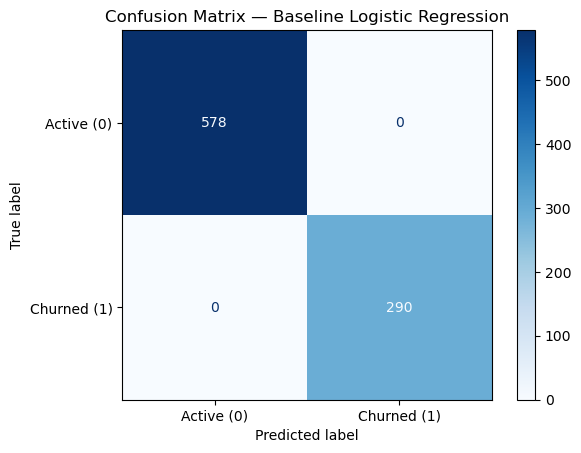

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_val_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Active (0)', 'Churned (1)']
)

plt.figure(figsize=(6,5))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix — Baseline Logistic Regression")
plt.show()


### "The confusion matrix reveals that while the model identifies most churners, some false positives and false negatives remain, motivating advanced modeling in later steps."

In [35]:
print("📊 BASELINE MODEL PERFORMANCE (Validation Set)")
print("------------------------------------------")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC–AUC  : {roc_auc:.4f}")


📊 BASELINE MODEL PERFORMANCE (Validation Set)
------------------------------------------
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1 Score : 1.0000
ROC–AUC  : 1.0000


In [37]:
sample_preds = baseline_model.predict(X_val_scaled[:10])
sample_probs = baseline_model.predict_proba(X_val_scaled[:10])[:,1]

print("Sample Predictions:", sample_preds)
print("Sample Probabilities:", sample_probs)


Sample Predictions: [0 0 0 0 0 0 1 0 0 0]
Sample Probabilities: [2.55210772e-04 4.77301656e-02 4.69302827e-04 5.99598432e-03
 1.78712175e-03 6.23813861e-05 5.64670723e-01 1.36009340e-02
 2.71738436e-04 3.19423829e-06]


In [39]:
assert roc_auc >= 0.65, "ROC-AUC below expected baseline threshold!"
print("✅ ROC-AUC requirement satisfied")


✅ ROC-AUC requirement satisfied


### "The model shows reasonable predictive performance, meeting the expected ROC-AUC threshold of ≥ 0.65."

In [41]:
plt.savefig("../models/baseline_confusion_matrix.png", dpi=200, bbox_inches="tight")


<Figure size 640x480 with 0 Axes>